In [109]:
import numpy as np
import pandas as pd

import random
import os
import py7zr
from tqdm import tqdm
from itertools import product
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
import pickle
from sklearn.metrics import mean_squared_error

In [110]:
plt.style.use('ggplot')

In [111]:
def set_seed(seed_value=33):
    random.seed(seed_value)
    np.random.seed(seed_value)

In [112]:
spectr_dir1 = 'spectr_data'
spectr_dir2 = 'spectr_data2'

In [113]:
def read_cu_data(file_name):
    cu_data = pd.read_csv(file_name, sep=' ', header=None, skiprows=1)
    cu_data.columns = ['label', 'FileName']
    cu_data['FileName'] = cu_data['FileName'].apply(
        lambda x: str(x).split('.')[0] + '.mca')
    return cu_data

In [114]:
cu_data1 = read_cu_data('Cu_conc_in_spectrum.txt')
cu_data1.head(2)

,label,FileName
0,1.75,67.mca
1,1.47,74.mca


In [115]:
cu_data2 = read_cu_data('Cu_conc_in_spectrum_2.txt')
cu_data2.head(2)

,label,FileName
0,19.23,7282_01_07_2024.mca
1,18.54,7296_02_07_2024.mca


In [116]:
windows = pd.read_csv('elements_windows.txt', sep=' ',
                      header=None, names=['Element', 'E1', 'E2'])
windows.head(2)

,Element,E1,E2
0,S,81,87
1,Ag,105,113


In [117]:
def parse_mca(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()
        data_start = False
        spectrum = []
        real_time = None

        for line in lines:
            stripped_line = line.strip()
            if stripped_line.startswith("REAL_TIME - "):
                try:
                    real_time = float(stripped_line.split("-")[1].strip())
                except ValueError:
                    pass
            if data_start:
                if stripped_line == "<<END>>":
                    break
                try:
                    spectrum.append(int(stripped_line))
                except ValueError:
                    continue
            if stripped_line == "<<DATA>>":
                data_start = True

        return np.array(spectrum), real_time

In [127]:
def create_data_frame(cu_data, spectr_dir):
    spectra = {}
    times = {}
    for filename in cu_data['FileName']:
        filepath = os.path.join(spectr_dir, filename)
        if os.path.exists(filepath):
            spec, real_time = parse_mca(filepath)
            if spec is not None and real_time is not None:
                spectra[filename] = spec
                times[filename] = real_time

    df = cu_data.copy()
    df['spectrum_arr'] = df['FileName'].map(spectra)
    df['time'] = df['FileName'].map(times)

    df = df.dropna(subset=['spectrum_arr', 'time'])

    for index, row in windows.iterrows():
        element = row['Element']
        ch1 = row['E1']
        ch2 = row['E2']
        df[element] = df.apply(
            lambda row: np.sum(row['spectrum_arr'][ch1:ch2+1]) / row['time']
            if ch1 < len(row['spectrum_arr']) and ch2 < len(row['spectrum_arr']) else 0,
            axis=1
        )
    return df

In [119]:
df1 = create_data_frame(cu_data1, spectr_dir1)
df1.head(2)

,label,FileName,spectrum_arr,time,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,...,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,1.75,67.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 159, 135, ...",59.814,9.429231,10.348748,8.476276,2928.177350,578.476611,4.982111,...,16.718494,297.472164,48.834721,1022.369345,198.231183,96.616177,110.509245,14.043535,1192.714080,266.442639
1,1.47,74.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 116, 103, 1...",59.744,5.908543,7.766470,9.674612,4017.959963,781.852571,3.464783,...,16.905463,297.134440,47.017274,1272.830745,239.388056,102.822041,104.730182,17.323915,649.320434,176.318961


In [120]:
df2 = create_data_frame(cu_data2, spectr_dir2)
df2.head(2)

,label,FileName,spectrum_arr,time,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,...,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,19.23,7282_01_07_2024.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 248, 227, ...",59.827,11.232387,11.165527,6.134354,1163.220619,241.212162,5.415615,...,23.016364,1813.612583,268.323667,913.183011,152.088522,86.282113,121.216173,7.555117,1467.731960,305.213365
1,18.54,7296_02_07_2024.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 244, 246, 264, ...",59.877,12.776191,13.143611,5.377691,1006.864071,203.199893,6.496651,...,20.892830,1524.358268,226.414149,715.015782,125.757803,79.162283,115.403243,6.329642,1729.328457,351.771131


In [121]:
feature_columns = df1.columns.difference(
    ['label', 'FileName', 'spectrum_arr', 'time'])

In [122]:
df1 = df1.drop(['FileName', 'spectrum_arr', 'time'], axis=1)
df1.head(2)

,label,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,1.75,9.429231,10.348748,8.476276,2928.177350,578.476611,4.982111,9.078142,18.156284,16.718494,297.472164,48.834721,1022.369345,198.231183,96.616177,110.509245,14.043535,1192.714080,266.442639
1,1.47,5.908543,7.766470,9.674612,4017.959963,781.852571,3.464783,9.172469,13.089181,16.905463,297.134440,47.017274,1272.830745,239.388056,102.822041,104.730182,17.323915,649.320434,176.318961


In [123]:
df2 = df2.drop(['FileName', 'spectrum_arr', 'time'], axis=1)
df2.head(2)

,label,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,19.23,11.232387,11.165527,6.134354,1163.220619,241.212162,5.415615,8.190282,21.996757,23.016364,1813.612583,268.323667,913.183011,152.088522,86.282113,121.216173,7.555117,1467.731960,305.213365
1,18.54,12.776191,13.143611,5.377691,1006.864071,203.199893,6.496651,7.882826,23.397966,20.892830,1524.358268,226.414149,715.015782,125.757803,79.162283,115.403243,6.329642,1729.328457,351.771131


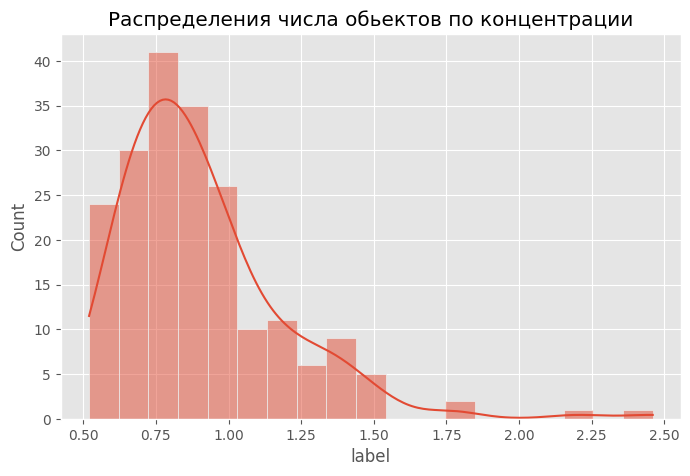

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(df1['label'], kde=True)
plt.title('Распределения числа обьектов по концентрации')
plt.show()

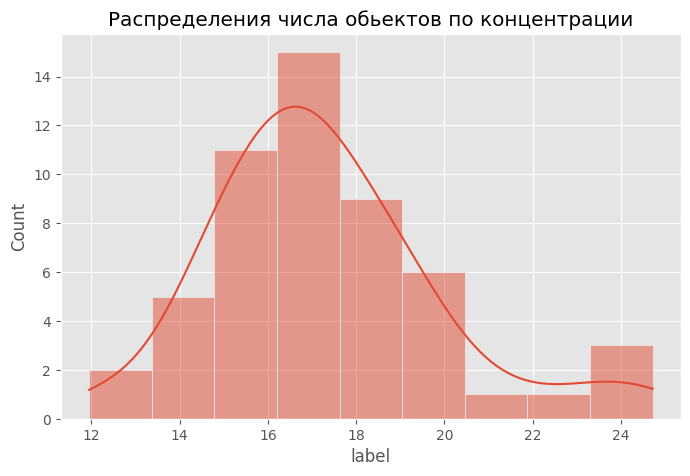

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df2['label'], kde=True)
plt.title('Распределения числа обьектов по концентрации')
plt.show()

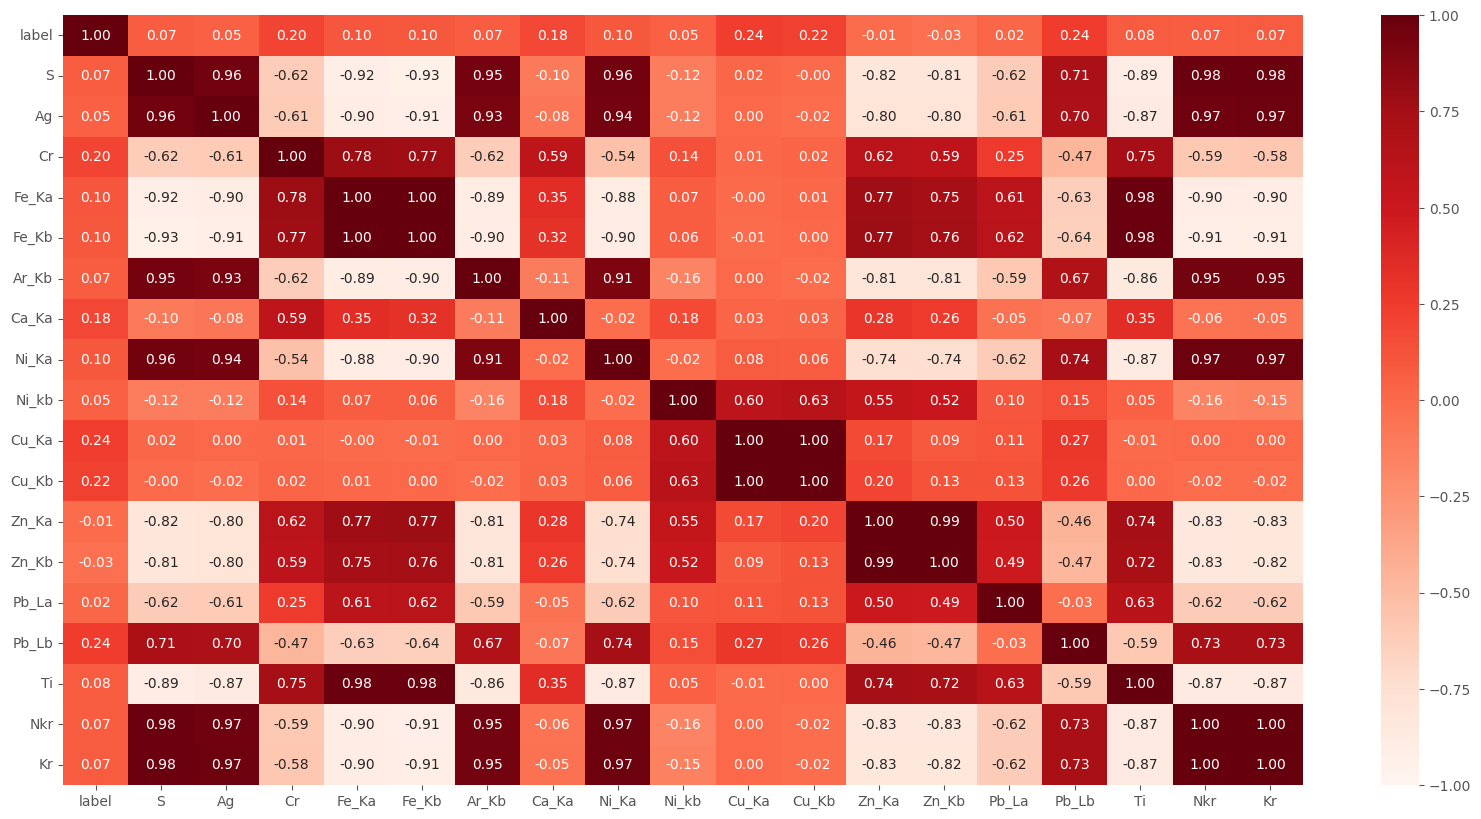

In [18]:
correlation_matrix1 = df1.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix1, annot=True,
            cmap='Reds', fmt='.2f', vmin=-1, vmax=1)
plt.show()

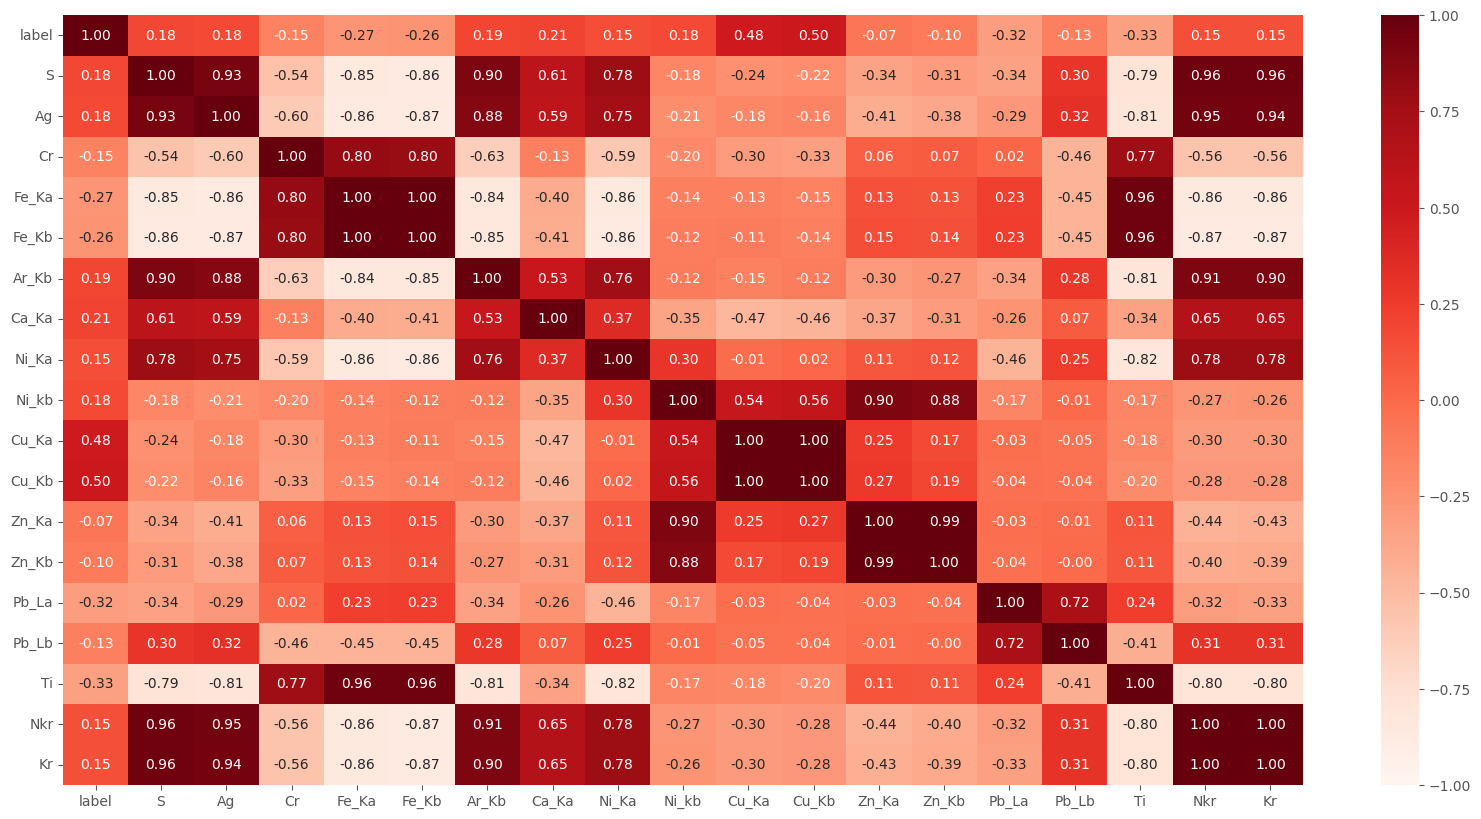

In [19]:
correlation_matrix2 = df2.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix2, annot=True,
            cmap='Reds', fmt='.2f', vmin=-1, vmax=1)
plt.show()

In [20]:
scaler_X1 = MinMaxScaler()
scaler_y1 = MinMaxScaler()

scaler_X2 = MinMaxScaler()
scaler_y2 = MinMaxScaler()

In [21]:
X1 = df1[feature_columns]
y1 = df1['label']

X1_scaled = scaler_X1.fit_transform(X1)
y1_scaled = scaler_y1.fit_transform(y1.values.reshape(-1, 1))

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1_scaled, y1_scaled, test_size=0.15, random_state=33)

In [22]:
X2 = df2[feature_columns]
y2 = df2['label']

X2_scaled = scaler_X2.fit_transform(X2)
y2_scaled = scaler_y2.fit_transform(y2.values.reshape(-1, 1))

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2_scaled, y2_scaled, test_size=0.2, random_state=52)

In [23]:
def create_train_data(X_train, X_test, y_train, y_test):
    train_data = [(np.array(x).reshape(-1, 1), y)
                  for x, y in zip(X_train.tolist(), y_train.tolist())]

    test_data = [(np.array(x).reshape(-1, 1), y)
                 for x, y in zip(X_test.tolist(), y_test.tolist())]

    return train_data, test_data

In [24]:
train_data1, test_data1 = create_train_data(
    X_train1, X_test1, y_train1, y_test1)

train_data2, test_data2 = create_train_data(
    X_train2, X_test2, y_train2, y_test2)

In [25]:
class Network(object):
    def __init__(self, sizes):
        set_seed(42)
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        set_seed(42)
        n = len(training_data)
        epoch_train_losses = []
        epoch_test_rmse = []
        epoch_test_r2 = []

        def calculate_r2(test_data):
            actual = []
            predicted = []
            for x, y in test_data:
                actual.append(y)
                predicted.append(self.feedforward(x))
            actual = np.array(actual).flatten()
            predicted = np.array(predicted).flatten()
            ss_total = np.sum((actual - np.mean(actual)) ** 2)
            ss_residual = np.sum((actual - predicted) ** 2)
            return 1 - (ss_residual / ss_total)

        with tqdm(range(epochs), desc="Training Progress") as pbar:
            for j in pbar:
                random.shuffle(training_data)
                mini_batches = [training_data[k:k + mini_batch_size]
                                for k in range(0, n, mini_batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, eta)

                epoch_train_loss = self.calculate_loss(training_data)
                epoch_train_losses.append(epoch_train_loss)

                if test_data:
                    epoch_rmse = self.calculate_rmse(test_data)
                    epoch_r2 = calculate_r2(test_data)
                    epoch_test_rmse.append(epoch_rmse)
                    epoch_test_r2.append(epoch_r2)

                    pbar.set_postfix(
                        train_loss=f"{epoch_train_loss:.4f}",
                        test_rmse=f"{epoch_rmse:.4f}",
                        test_r2=f"{epoch_r2:.4f}"
                    )
                else:
                    pbar.set_postfix(train_loss=f"{epoch_train_loss:.4f}")

        return epoch_train_losses, epoch_test_rmse, epoch_test_r2

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta / len(mini_batch)) *
                        nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b,
                       nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        delta = self.cost_derivative(
            activations[-1], y) * self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def calculate_loss(self, data):
        loss = 0
        for x, y in data:
            output = self.feedforward(x)
            loss += np.sum((output - y) ** 2)
        return loss / len(data)

    def calculate_rmse(self, test_data):
        actual = []
        predicted = []
        for x, y in test_data:
            actual.append(y)
            predicted.append(self.feedforward(x))
        actual = np.array(actual).flatten()
        predicted = np.array(predicted).flatten()
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        return rmse

    def calculate_r2(self, test_data):
        actual = []
        predicted = []
        for x, y in test_data:
            actual.append(y)
            predicted.append(self.feedforward(x))
        actual = np.array(actual).flatten()
        predicted = np.array(predicted).flatten()
        ss_residual = np.sum((actual - predicted) ** 2)
        ss_total = np.sum((actual - np.mean(actual)) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

In [38]:
import matplotlib.pyplot as plt


def plot_rmse(train_losses, test_rmse=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Левый график - Train Loss
    axes[0].plot(range(1, len(train_losses) + 1), train_losses,
                 label='train loss')
    axes[0].set_title('train loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].grid(True)
    axes[0].legend(loc='best')
    if test_rmse:
        axes[1].plot(range(1, len(test_rmse) + 1), test_rmse,
                     label='test rmse', color='orange')
        axes[1].set_title('test rmse')
        axes[1].set_xlabel('epoch')
        axes[1].set_ylabel('rmse')
        axes[1].grid(True)
        axes[1].legend(loc='best')
    else:
        axes[1].text(0.5, 0.5, 'No Test RMSE Provided', ha='center',
                     va='center', transform=axes[1].transAxes)

    # Отображение графиков
    plt.tight_layout()
    plt.show()

In [27]:
def get_predictions(model, test_data, scaler):
    predictions = []
    for x, _ in test_data:
        predictions.append(model.feedforward(x))

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1))
    return predictions


def plot_predictions(test_data, predictions, scaler):
    true_values = [y for _, y in test_data]

    true_values = scaler.inverse_transform(
        np.array(true_values).reshape(-1, 1))

    predicted_values = predictions.flatten()

    r2 = r2_score(true_values, predicted_values)

    plt.figure(figsize=(10, 6))

    plt.plot(range(len(test_data)), true_values, label='True Values',
             color='blue', marker='o', linestyle='-', markersize=6)
    plt.plot(range(len(test_data)), predicted_values, label='Predictions',
             color='red', marker='s', linestyle='--', markersize=6)

    plt.xlabel('Object')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    plt.show()

    print(f'R^2 = {r2:.2f}')

In [178]:
layer1_1 = 38
layer2_1 = 19
epochs1 = 1000
eta1 = 1
batch_size1 = 1

In [179]:
net1 = Network([len(feature_columns), layer1_1, layer2_1, 1])

Training Progress: 100%|██████████| 1000/1000 [00:40<00:00, 24.46it/s, test_r2=0.8850, test_rmse=0.0413, train_loss=0.0025]


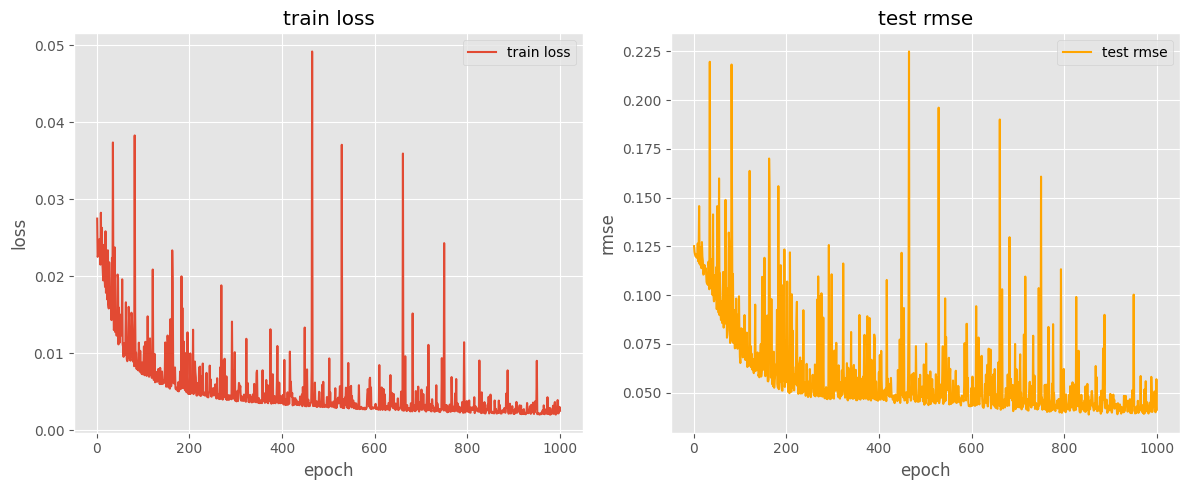

In [180]:
train_loss1, test_rmse1, test_r2 = net1.SGD(
    train_data1, epochs=epochs1, mini_batch_size=batch_size1, eta=eta1, test_data=test_data1)
plot_rmse(train_loss1, test_rmse1)

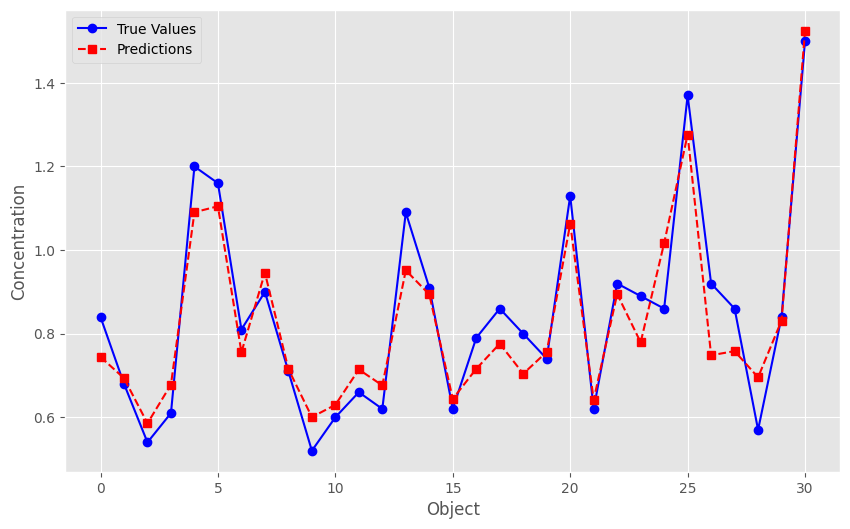

R^2 = 0.89


In [182]:
predictions1 = get_predictions(net1, test_data1, scaler_y1)
plot_predictions(test_data1, predictions1, scaler_y1)

In [232]:
layer1_2 = 19
layer2_2 = 8
epochs2 = 2000
eta2 = 0.1
batch_size2 = 1

In [233]:
net2 = Network([len(feature_columns), layer1_2, layer2_2, 1])

Training Progress: 100%|██████████| 2000/2000 [00:26<00:00, 76.42it/s, test_r2=0.8806, test_rmse=0.0674, train_loss=0.0021]


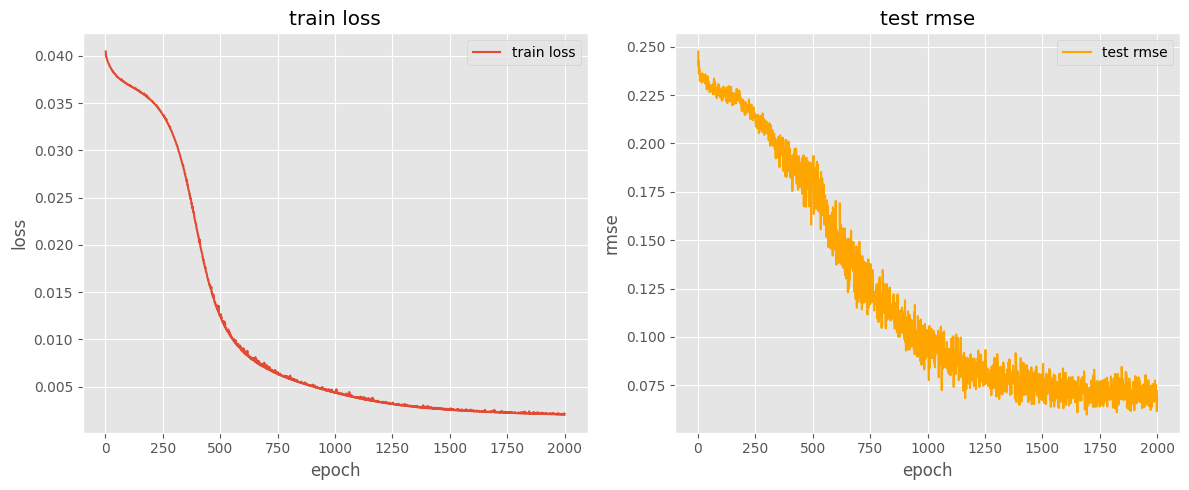

In [234]:
train_loss2, test_rmse2, test_r2_2 = net2.SGD(
    train_data2, epochs=epochs2, mini_batch_size=batch_size2, eta=eta2, test_data=test_data2)
plot_rmse(train_loss2, test_rmse2)

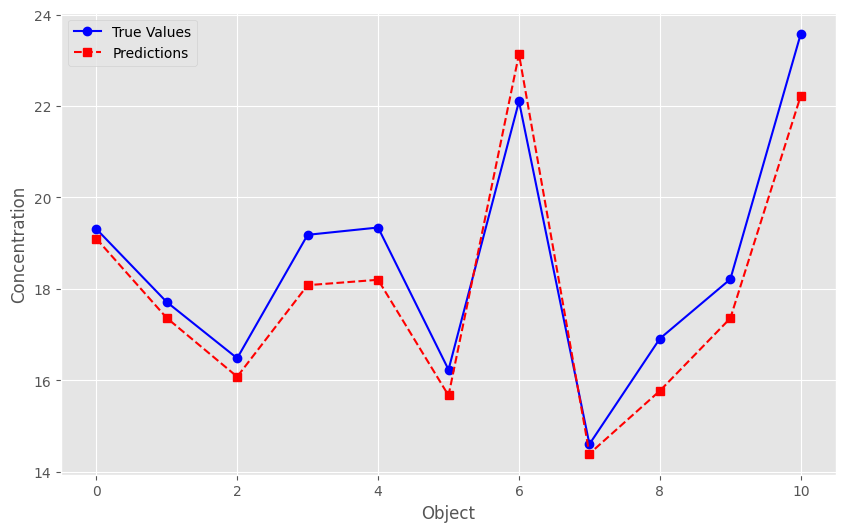

R^2 = 0.88


In [235]:
predictions2 = get_predictions(net2, test_data2, scaler_y2)
plot_predictions(test_data2, predictions2, scaler_y2)

In [560]:
def drop_features(df1):
    correlation_matrix1 = df1.drop(columns=['label']).corr()
    label_correlation1 = df1.corr()['label']
    columns_to_drop1 = set()
    for col1 in correlation_matrix1.columns:
        for col2 in correlation_matrix1.columns:
            if col1 != col2 and (correlation_matrix1.loc[col1, col2] > 0.95):
                if label_correlation1[col1] >= label_correlation1[col2]:
                    columns_to_drop1.add(col2)
                else:
                    columns_to_drop1.add(col1)

    return df1.drop(columns=columns_to_drop1)

In [561]:
df1_1 = drop_features(df1)
df1_1.head(2)

,label,Cr,Fe_Ka,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Zn_Ka,Pb_La,Pb_Lb
0,1.75,8.476276,2928.177350,4.982111,9.078142,18.156284,16.718494,297.472164,1022.369345,96.616177,110.509245
1,1.47,9.674612,4017.959963,3.464783,9.172469,13.089181,16.905463,297.134440,1272.830745,102.822041,104.730182


In [562]:
df2_1 = drop_features(df2)
df2_1.head(2)

,label,S,Ag,Cr,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Kb,Zn_Ka,Pb_La,Pb_Lb
0,19.23,11.232387,11.165527,6.134354,241.212162,5.415615,8.190282,21.996757,23.016364,268.323667,913.183011,86.282113,121.216173
1,18.54,12.776191,13.143611,5.377691,203.199893,6.496651,7.882826,23.397966,20.892830,226.414149,715.015782,79.162283,115.403243


In [563]:
scaler_X1_1 = MinMaxScaler()
scaler_y1_1 = MinMaxScaler()

scaler_X2_1 = MinMaxScaler()
scaler_y2_1 = MinMaxScaler()

In [564]:
feature_columns1 = df1_1.columns.difference(['label'])

feature_columns2 = df2_1.columns.difference(['label'])

In [565]:
X1_1 = df1_1[feature_columns1]
y1_1 = df1_1['label']

X1_1_scaled = scaler_X1_1.fit_transform(X1_1)
y1_1_scaled = scaler_y1_1.fit_transform(y1_1.values.reshape(-1, 1))

X_train1_1, X_test1_1, y_train1_1, y_test1_1 = train_test_split(
    X1_1_scaled, y1_1_scaled, test_size=0.15, random_state=33)

In [566]:
X2_1 = df2_1[feature_columns2]
y2_1 = df2_1['label']

X2_1_scaled = scaler_X2_1.fit_transform(X2_1)
y2_1_scaled = scaler_y2_1.fit_transform(y2_1.values.reshape(-1, 1))

X_train2_1, X_test2_1, y_train2_1, y_test2_1 = train_test_split(
    X2_1_scaled, y2_1_scaled, test_size=0.2, random_state=52)

In [567]:
train_data1_1, test_data1_1 = create_train_data(
    X_train1_1, X_test1_1, y_train1_1, y_test1_1)

train_data2_1, test_data2_1 = create_train_data(
    X_train2_1, X_test2_1, y_train2_1, y_test2_1)

In [578]:
len(feature_columns2)

12

In [681]:
layer1_1 = 12
layer2_1 = 12
epochs1 = 7000
eta1 = 1
batch_size1 = 170

In [682]:
net2_1 = Network([len(feature_columns2), layer1_1, layer2_1, 1])

Training Progress: 100%|██████████| 7000/7000 [01:12<00:00, 96.04it/s, test_r2=0.7772, test_rmse=0.0921, train_loss=0.0029]  


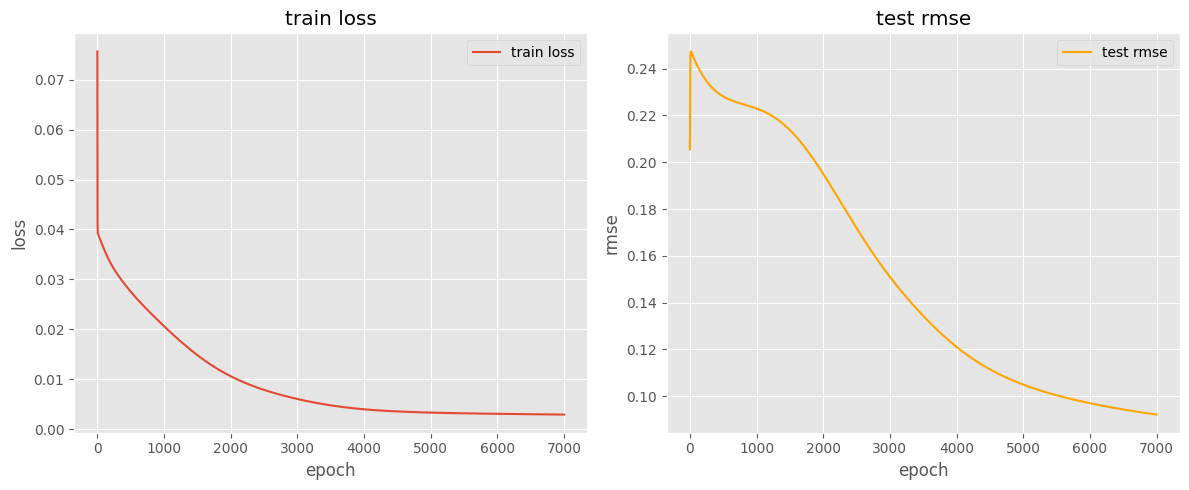

In [683]:
train_loss2_1, test_rmse2_1, test_r2_2_1 = net2_1.SGD(
    train_data2_1, epochs=epochs1, mini_batch_size=batch_size1, eta=eta1, test_data=test_data2_1)
plot_rmse(train_loss2_1, test_rmse2_1)

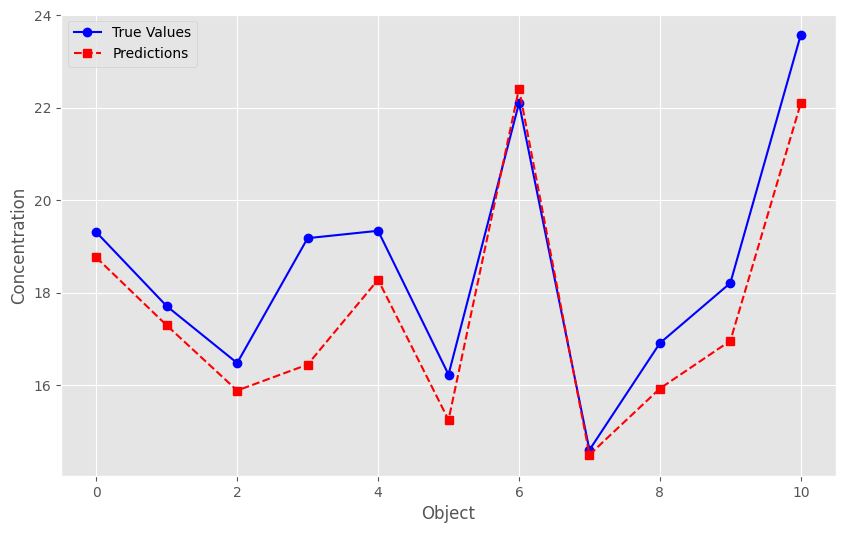

R^2 = 0.78


In [684]:
predictions2_1 = get_predictions(net2_1, test_data2_1, scaler_y2_1)
plot_predictions(test_data2_1, predictions2_1, scaler_y2_1)

In [685]:
spectr_data_test_dir = 'spectr_data_test'

In [524]:
data = pd.DataFrame([x for x in range(1, 20)])
data.head()

,0
0,1
1,2
2,3
3,4
4,5


In [525]:
data.columns = ['FileName']
data['FileName'] = data['FileName'].apply(
    lambda x: str(x).split('.')[0] + '.mca')
data.head()

,FileName
0,1.mca
1,2.mca
2,3.mca
3,4.mca
4,5.mca


In [626]:
df = create_data_frame(data, spectr_data_test_dir)

In [627]:
df.head(3)

,FileName,spectrum_arr,time,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,...,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,1.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 193, 190, 217, ...",59.814,12.655900,11.903568,5.935065,1312.100846,262.680978,5.884910,7.657070,...,20.045474,1405.774568,210.268499,822.616779,146.153075,88.725048,115.842445,7.941285,1514.896178,314.809242
1,2.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 244, 247, ...",59.812,12.840233,13.057580,5.885107,1017.989701,206.095767,6.403397,7.590450,...,22.018993,1581.087407,232.177489,865.478499,150.086939,95.348759,135.942620,6.687621,1676.252257,340.600548
2,3.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 214, 224, ...",59.814,12.689337,12.254656,6.118969,1162.503762,237.419333,5.433511,8.676898,...,21.249206,1451.650115,217.106363,915.387702,159.594744,99.006921,133.447019,7.657070,1578.092085,326.227973


In [628]:
df = df.drop(['FileName', 'spectrum_arr', 'time'], axis=1)
df.head(2)

,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,12.655900,11.903568,5.935065,1312.100846,262.680978,5.884910,7.65707,19.895008,20.045474,1405.774568,210.268499,822.616779,146.153075,88.725048,115.842445,7.941285,1514.896178,314.809242
1,12.840233,13.057580,5.885107,1017.989701,206.095767,6.403397,7.59045,21.651174,22.018993,1581.087407,232.177489,865.478499,150.086939,95.348759,135.942620,6.687621,1676.252257,340.600548


In [629]:
feature_columns = df.columns

In [630]:
X = df[feature_columns]
X_scaled = scaler_X2.fit_transform(X)

In [631]:
X_imp_ftr = df[feature_columns2]
X_imp_ftr_scaled = scaler_X2_1.fit_transform(X_imp_ftr)

In [634]:
test = [np.array(x).reshape(-1, 1) for x in X_scaled.tolist()]
test_imp_ftr = [np.array(x).reshape(-1, 1) for x in X_imp_ftr_scaled.tolist()]

In [635]:
len(X_imp_ftr_scaled)

19

In [658]:
preds1 = [net2.feedforward(x) for x in test]
preds2 = [net2_1.feedforward(x) for x in test_imp_ftr]

preds1 = scaler_y2.inverse_transform(
    np.array(preds1).reshape(-1, 1))
preds2 = scaler_y2_1.inverse_transform(
    np.array(preds2).reshape(-1, 1))

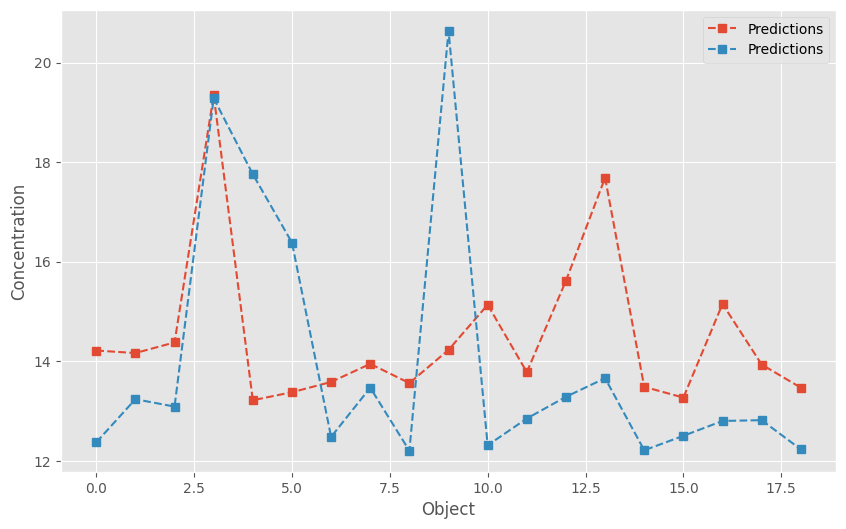

In [687]:
preds_values1 = preds1.flatten()
preds_values2 = preds2.flatten()

plt.figure(figsize=(10, 6))

plt.plot(range(len(test)), preds_values1, label='Predictions',
         marker='s', linestyle='--', markersize=6)
plt.plot(range(len(test)), preds_values2, label='Predictions',
         marker='s', linestyle='--', markersize=6)

plt.xlabel('Object')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()